In [26]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


In [45]:
feature_columns = [ 'Volume of aeration tanks (m3)', 'Actual Inf rate (m3/d)', '℃ Temp.Max.SamplingDate', '℃ Temp.Avg.SamplingDate', '℃ Temp.Min.SamplingDate', '℃ Dew.Max.SamplingDate',
 '℃ Dew.Avg.SamplingDate', '℃ Dew.Min.SamplingDate', '℃ Humidity.Max.SamplingDate', '℃ Humidity.Min.SamplingDate', '℃ Wind.Max.SamplingDate', '℃ Wind.Min.SamplingDate',
 '℃ Pressure.Max.SamplingDate', '℃ Pressure.Min.SamplingDate', '℃ Precipitation.SamplingDate', '℃ Temp.Max.WeekMean', '℃ Temp.Avg.WeekMean', '℃ Temp.Min.WeekMean',
 '℃ Dew.Max.WeekMean', '℃ Dew.Avg.WeekMean', '℃ Dew.Min.WeekMean', '℃ Humidity.Max.WeekMean', '℃ Humidity.Min.WeekMean', '℃ Wind.Max.WeekMean', '℃ Wind.Min.WeekMean',
 '℃ Pressure.Max.WeekMean', '℃ Pressure.Min.WeekMean', '℃ Precipitation.WeekMean', '℃ Temp.Max.WeekMax', '℃ Temp.Avg.WeekMax', '℃ Temp.Min.WeekMax', '℃ Dew.Max.WeekMax',
 '℃ Dew.Avg.WeekMax', '℃ Dew.Min.WeekMax', '℃ Humidity.Max.WeekMax', '℃ Humidity.Min.WeekMax', '℃ Wind.Max.WeekMax', '℃ Wind.Min.WeekMax', '℃ Pressure.Max.WeekMax',
 '℃ Pressure.Min.WeekMax', '℃ Precipitation.WeekMax', '℃ Precipitation.WeekAccum', '℃ Precipitation.MonthAccum', '℃ Ambient temperature (℃)', 
 'COD (mg/l) In', 'BOD7 (mg/l) In', 'NH3 (mg/L) In', 'Total Nitrogen (mg/L) In', 
 'Total Phosphorus (mg/L) In', 'pH AS', 'DO (mg/L) AS', 'Temp (oC) AS', 'MLSS (mg/l) AS', 'MLVSS (mg/l) AS', 'SVI (ml/g) AS',
 'SRT (days)', 'Precip (inch)', 'Position_enc', 'Country_enc', 'City_enc', 'Plant_enc', 'Year', 'Month', 'Day', 'Weekday', ]

target_column = ['performance_class']

In [74]:
original_df = pd.read_csv("../0. Data/performance_class_data_250326.csv")
original_df = original_df.fillna(original_df.mean())
original_df = original_df.drop(columns=['Recycle ratio (total return sludge flow/total influent flow)', 'Recycle ratio (total return sludge flow/total influent flow).1'])

original_df['performance_class'] = original_df['efficiency'].apply(lambda x: 1 if x > 0.9 else  0)
# (lambda x: 2 if x > 0.9 else 1 if x > 0.8 else 0)
original_df['performance_class'].value_counts()


performance_class
0    858
1    393
Name: count, dtype: int64

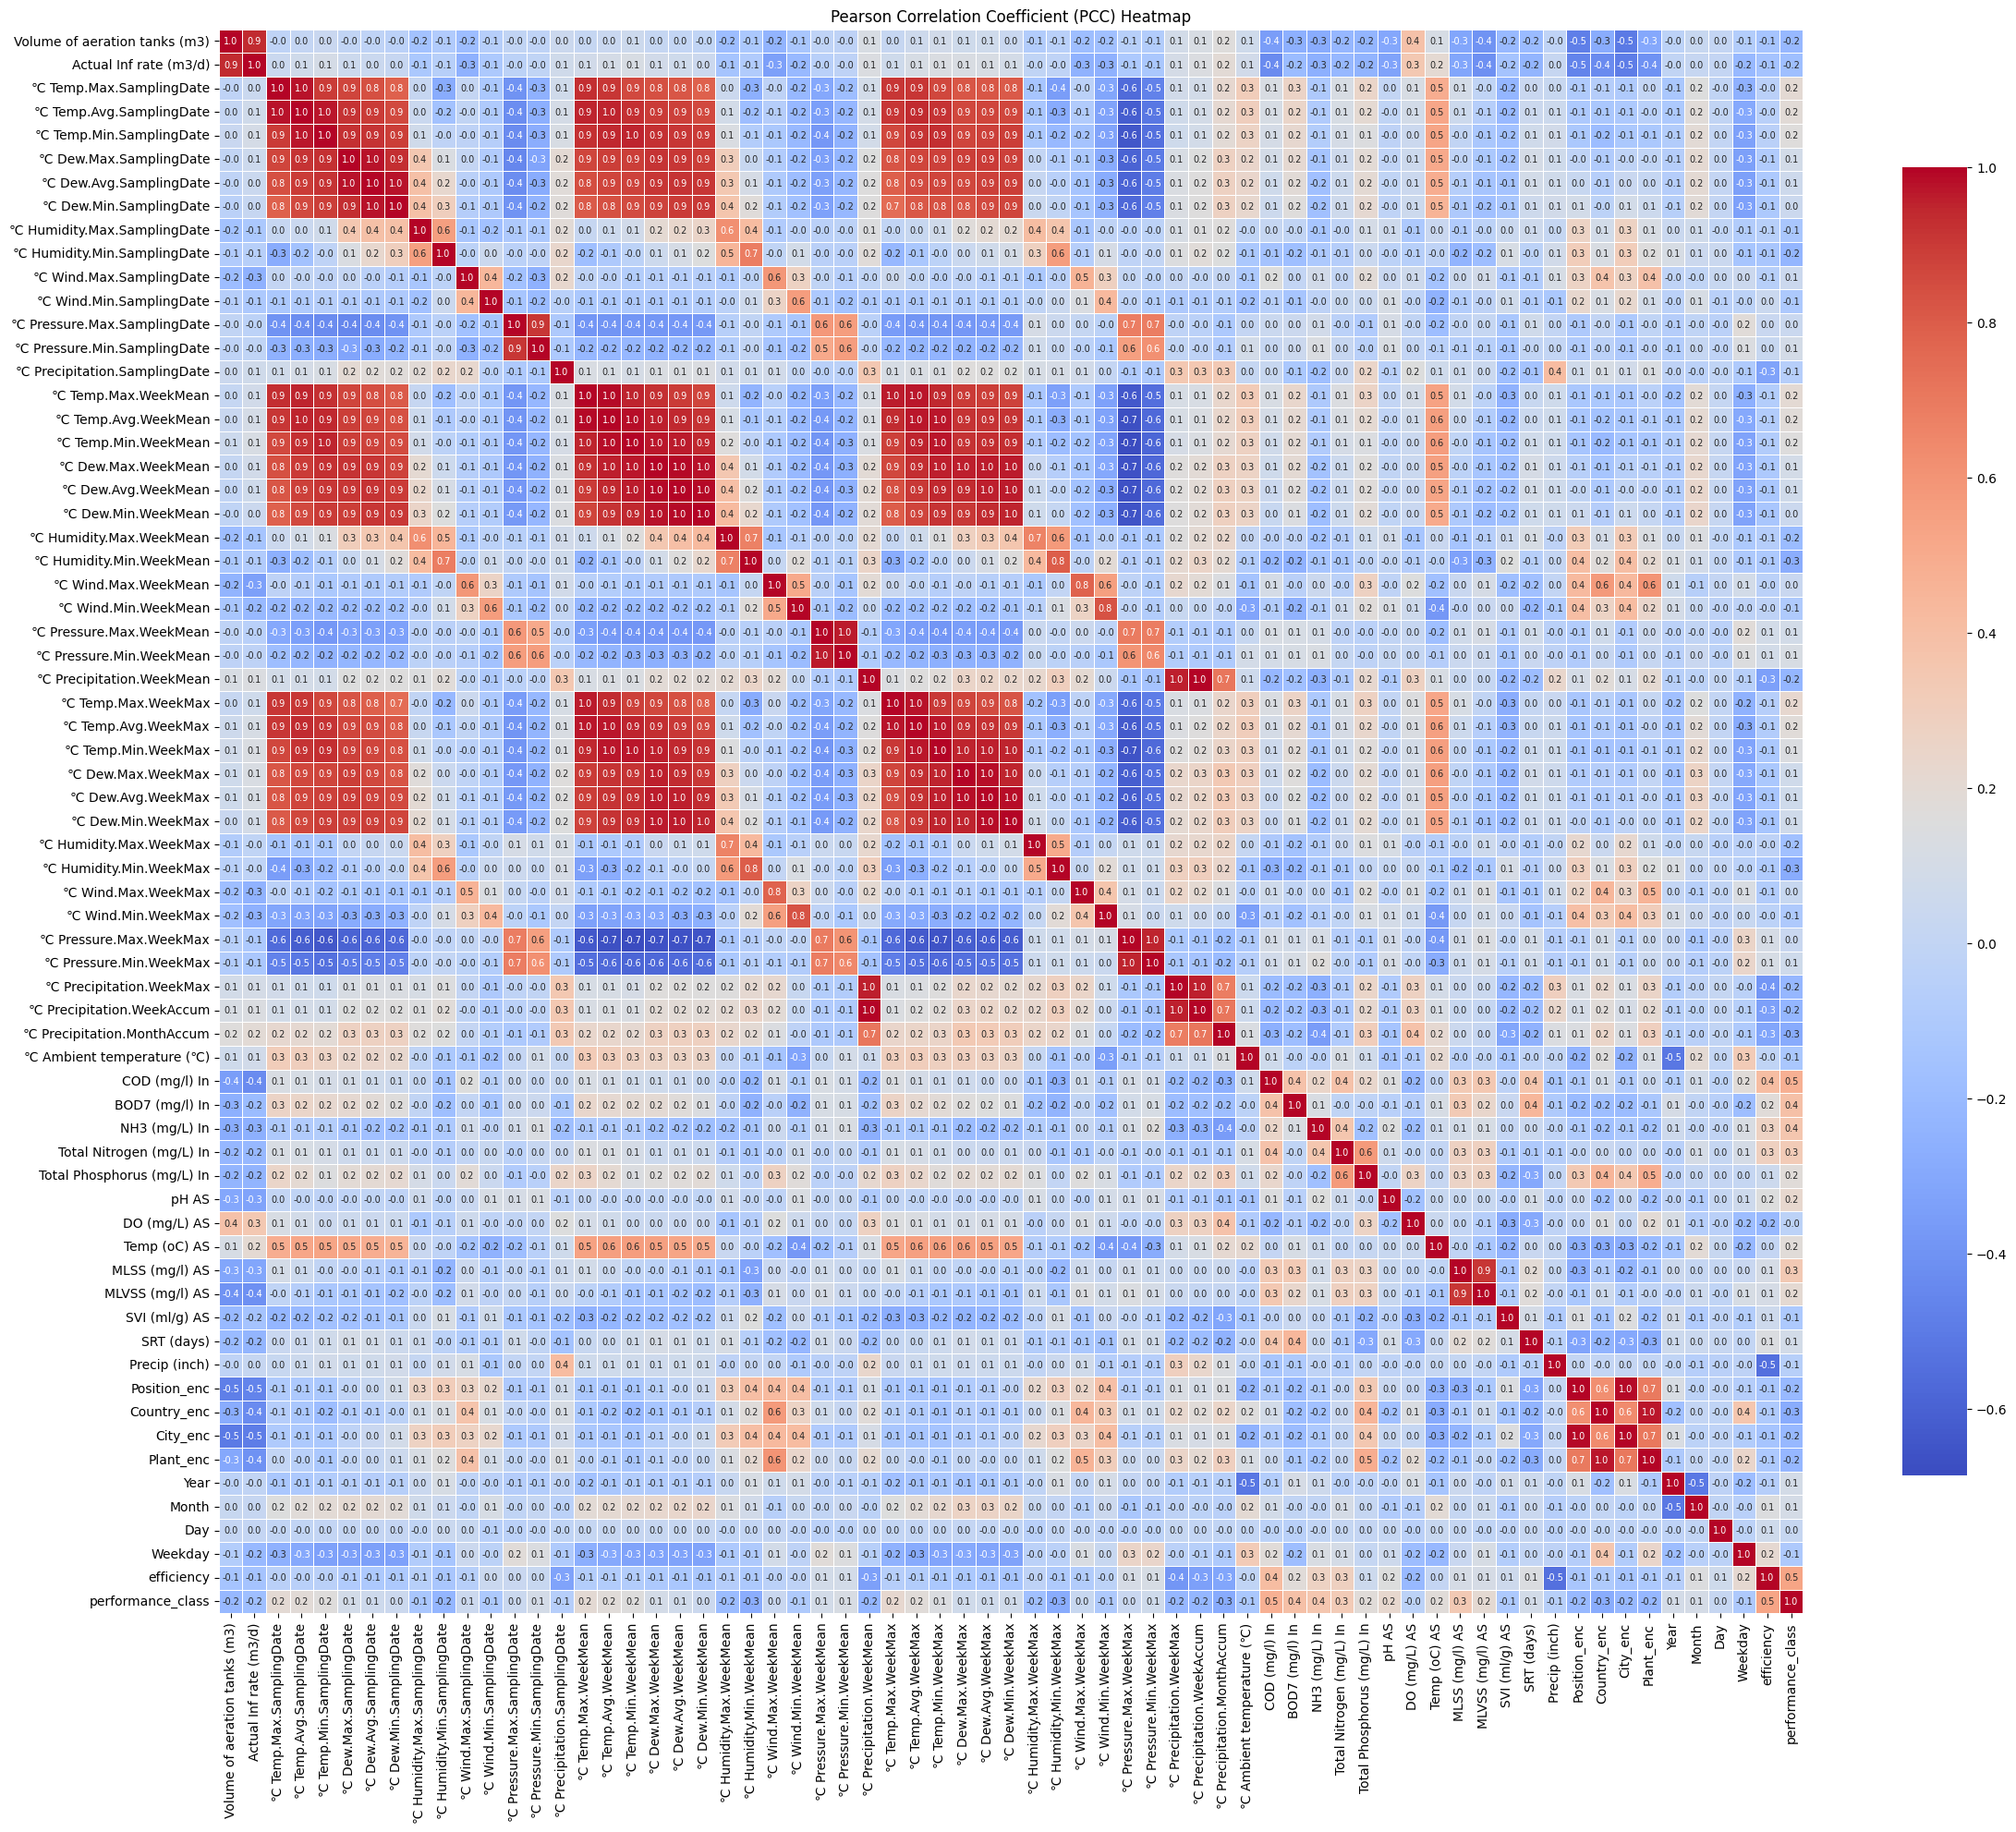

In [47]:
# 🔹 상관계수 행렬 계산 (PCC)
corr_matrix = original_df.corr(method='pearson')

# 🔹 히트맵 시각화
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": .8}, linewidths=0.5, annot_kws={"size": 7})
plt.title("Pearson Correlation Coefficient (PCC) Heatmap")
plt.tight_layout()
plt.show()

In [75]:
X = original_df[feature_columns]

y = original_df[target_column].squeeze() 

In [76]:
# 🔹 3. Split the data into training and test sets (70:30 split with random seed 1004)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1004)

# 🔹 4. Normalize feature values using standard scaling (zero mean, unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("NaNs in X_train:", np.isnan(X_train_scaled).sum())
print("NaNs in y_train:", np.isnan(y_train).sum())
print("Infs in X_train:", np.isinf(X_train_scaled).sum())
print("Infs in y_train:", np.isinf(y_train).sum())


NaNs in X_train: 0
NaNs in y_train: 0
Infs in X_train: 0
Infs in y_train: 0


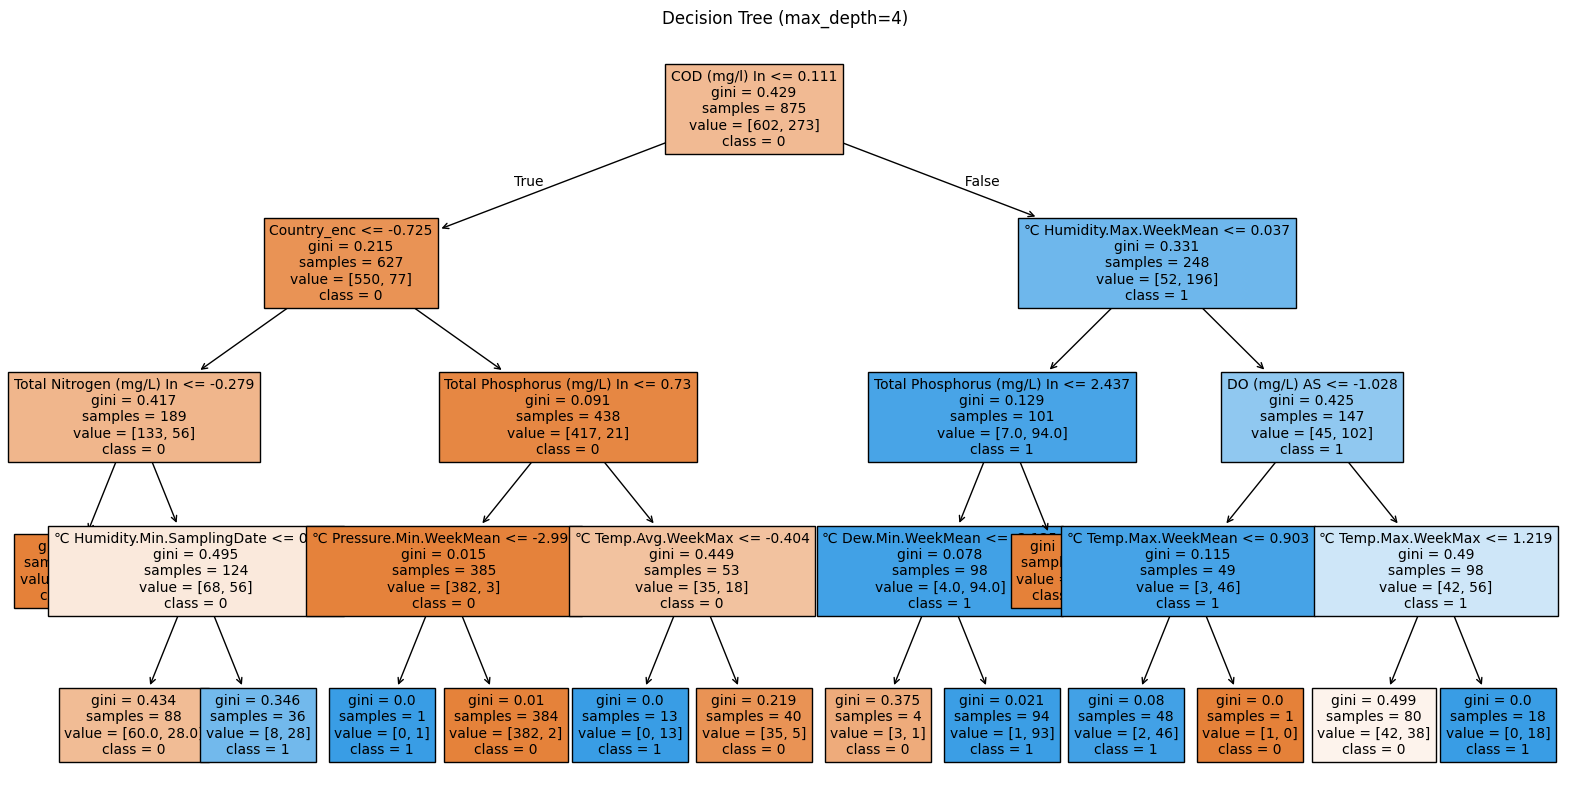

In [77]:
# 🔹 1. 모델 학습
clf = DecisionTreeClassifier(max_depth=4, random_state=1004)
clf.fit(X_train_scaled, y_train)

# 🔹 2. 트리 구조 시각화
plt.figure(figsize=(20, 10))
plot_tree(clf,
          feature_names=X.columns,
          class_names=[str(c) for c in sorted(y.unique())],
          filled=True,
          fontsize=10)
plt.title("Decision Tree (max_depth=4)")
plt.show()



In [82]:
# 🔹 3. 성능 평가
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.87      0.96      0.91       256
           1       0.89      0.70      0.79       120

    accuracy                           0.88       376
   macro avg       0.88      0.83      0.85       376
weighted avg       0.88      0.88      0.87       376



In [78]:
# 🔹 4. SHAP 설명 준비 (입력을 DataFrame으로 변환)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

explainer = shap.Explainer(clf, X_train_scaled_df)
shap_values = explainer(X_train_scaled_df)  # shap_values는 Explanation 객체



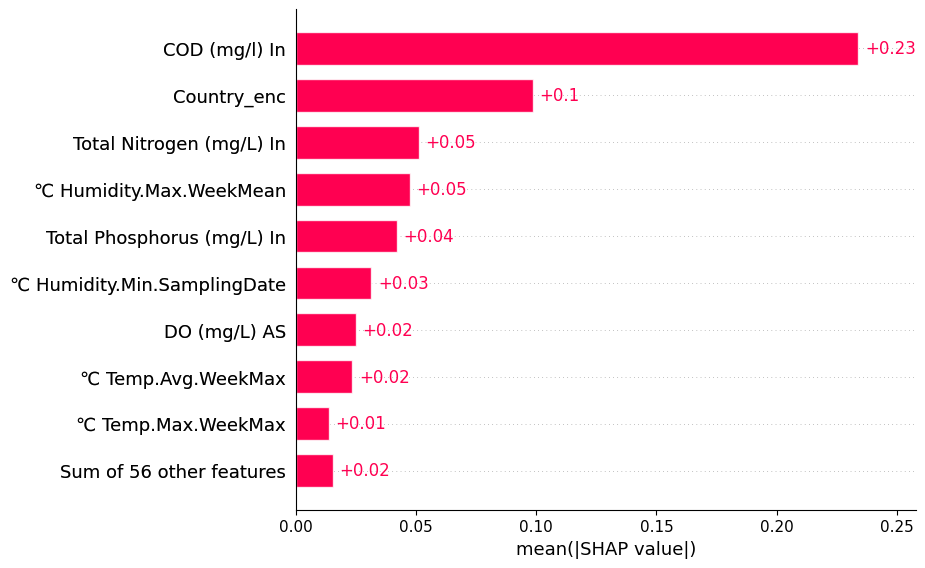

In [79]:
# 예: 클래스 0에 대한 전역 feature importance 시각화
shap.plots.bar(shap_values[:, :, 0])  # 중요! 다중 클래스는 이렇게 slicing해야 함


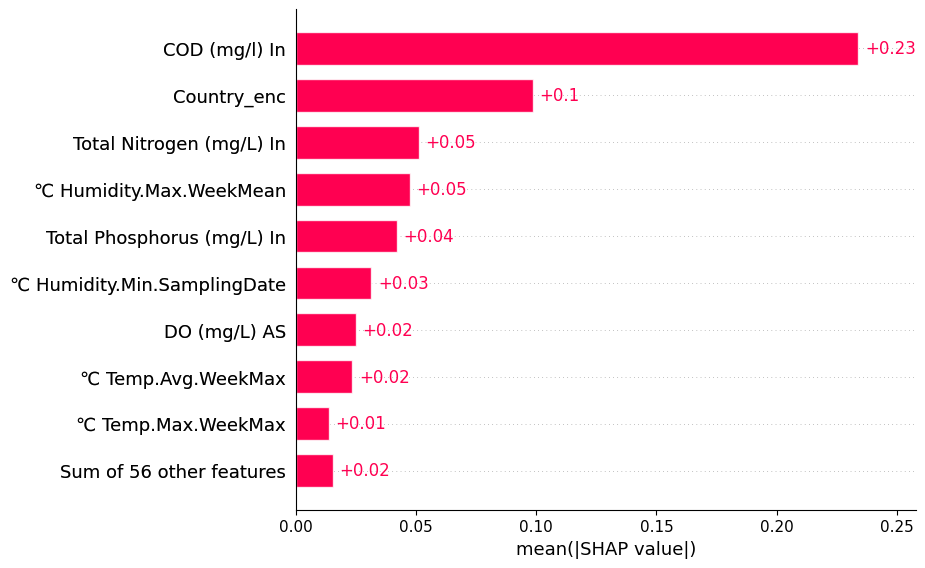

In [80]:
shap.plots.bar(shap_values[:, :, 1]) 

In [81]:
shap.plots.bar(shap_values[:, :, 2]) 

IndexError: index 2 is out of bounds for axis 2 with size 2